# Denoising

This notebook illustrates 4-D image denoising with [_Dynamic PET_].

First, we download a 4-D PET image with its [PET-BIDS] json sidecar from
[OpenNeuro](https://openneuro.org/):

[_Dynamic PET_]: https://github.com/bilgelm/dynamicpet
[PET-BIDS]: https://bids-specification.readthedocs.io/en/stable/modality-specific-files/positron-emission-tomography.html

In [1]:
from pathlib import Path

import requests


outdir = Path.cwd() / "nb_data"
outdir.mkdir(exist_ok=True)

petjson_fname = outdir / "pet_to_denoise.json"
pet_fname = outdir / "pet_to_denoise.nii.gz"

# we will download the PET for the baseline session for subject 01 from
# https://openneuro.org/datasets/ds001420/versions/1.2.0
baseurl = "https://s3.amazonaws.com/openneuro.org/ds001420/sub-01/ses-baseline/"

peturl = (
    baseurl
    + "pet/sub-01_ses-baseline_pet.nii.gz"
    + "?versionId=8Qon4IjB8ejnZq7JgCUlFJhLUYSG1zJB"
)

if not petjson_fname.exists():
    r = requests.get(
        baseurl
        + "pet/sub-01_ses-baseline_pet.json"
        + "?versionId=rLpwPCPOzgW1MduO53VKxsKGuD5K0j5R",
        timeout=10,
    )
    r.raise_for_status()
    with open(petjson_fname, "wb") as f:
        f.write(r.content)

if not pet_fname.exists():
    with requests.get(peturl, timeout=10, stream=True) as r:
        r.raise_for_status()
        with open(pet_fname, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

## Denoise

We read in a PET image and apply HYPR-LR denoising.

In [2]:
from dynamicpet.denoise.hypr import hypr_lr
from dynamicpet.petbids.petbidsimage import load


pet = load(pet_fname)
pet_hyprlr = hypr_lr(pet, fwhm=5)

## Visualize result

We inspect the middle time frame without and with HYPR-LR denoising.

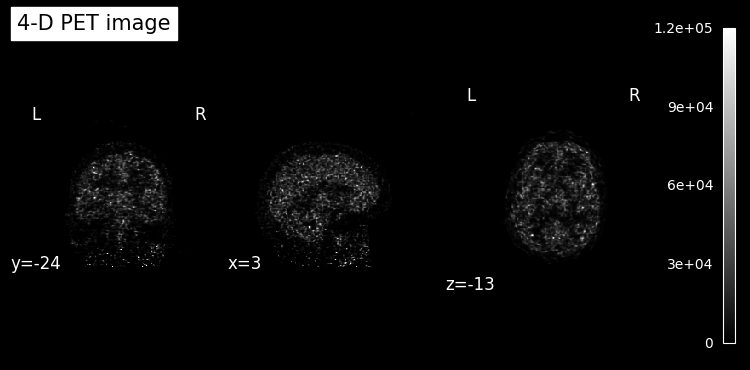

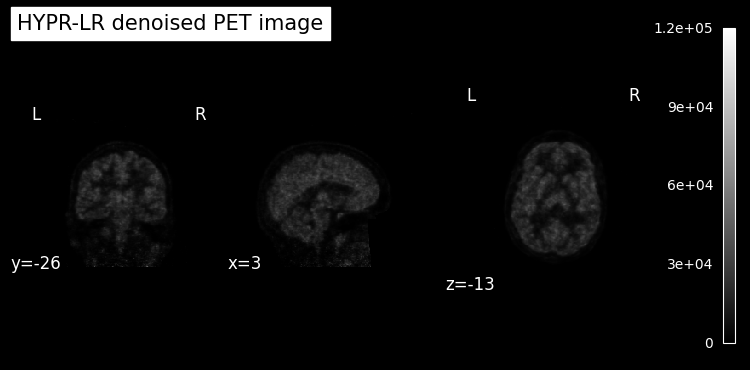

In [3]:
from nilearn.image import index_img
from nilearn.plotting import plot_anat


# get mid slice index (slice 16)
slice_index = pet.num_frames // 2

# pick common colorbar limits
vmin = 0
vmax = 1.2e5

plot_anat(
    index_img(pet.img, slice_index),
    title="4-D PET image",
    colorbar=True,
    draw_cross=False,
    vmin=vmin,
    vmax=vmax,
)

# plot HYPR-LR denoised image
plot_anat(
    index_img(pet_hyprlr.img, slice_index),
    title="HYPR-LR denoised PET image",
    colorbar=True,
    draw_cross=False,
    vmin=vmin,
    vmax=vmax,
);

We can also look at the time activity curve for a single voxel.

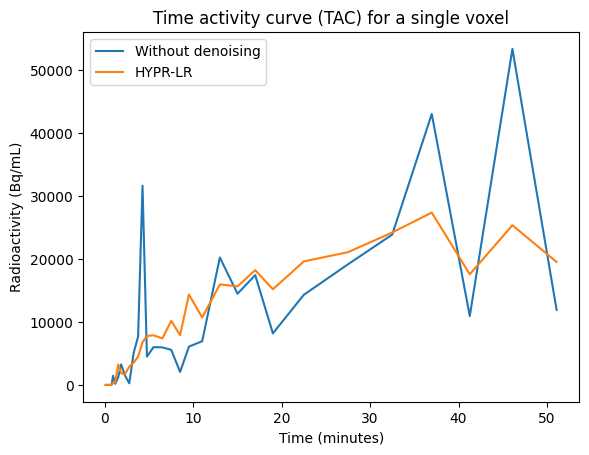

In [4]:
import matplotlib.pyplot as plt


voxel_index = (100, 100, 100)  # an arbitrarily selected voxel

time = pet.frame_mid
pet_tac = pet.dataobj[*voxel_index, ...]
pet_hyprlr_tac = pet_hyprlr.dataobj[*voxel_index, ...]

plt.figure()
plt.plot(time, pet_tac, label="Without denoising")
plt.plot(time, pet_hyprlr_tac, label="HYPR-LR")
plt.xlabel("Time (minutes)")
plt.ylabel(f'Radioactivity ({pet.json_dict["Units"]})')
plt.title("Time activity curve (TAC) for a single voxel")
plt.legend();

## Command line interface

Instead of using the Python API, we can also perform denoising via the
command line:

In [5]:
!denoise --method HYPRLR --fwhm 5 --outputdir nb_data nb_data/pet_to_denoise.nii.gz